## Готовим LDA по рецептам

Коллекцией состоит из рецептов блюд разных кухонь. Тематические модели ищут слова, которые часто вместе встречаются в документах, и составляют из них темы. Мы попробуем применить эту идею к рецептам и найти кулинарные «темы». Эта задача достаточно наглядно иллюстрирует принцип работы тематических моделей.


### Загрузка данных

Коллекция дана в json-формате: для каждого рецепта известны его id, кухня (cuisine) и список ингредиентов, в него входящих.

In [ ]:
import json
import scipy
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#загружаем данные
with open("/content/drive/MyDrive/coursera/recipes.json") as f:
    recipes = json.load(f)

In [ ]:
print(recipes[0])

{'id': 10259, 'cuisine': 'greek', 'ingredients': ['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']}


### Составление корпуса

In [ ]:
from gensim import corpora, models
import numpy as np

Gensim работает с данными, которые должны быть представлена в виде списка списков, каждый внутренний список соответствует отдельному документу и состоит из его слов.

Преобразуем наши данные в такой формат, а затем создадим объекты corpus и dictionary, с которыми будет работать модель.

In [ ]:
texts = [recipe["ingredients"] for recipe in recipes]
dictionary = corpora.Dictionary(texts)   # составляем словарь
corpus = [dictionary.doc2bow(text) for text in texts]  # составляем корпус документов

In [ ]:
print (texts[2])
print (corpus[2])

['eggs', 'pepper', 'salt', 'mayonaise', 'cooking oil', 'green chilies', 'grilled chicken breasts', 'garlic powder', 'yellow onion', 'soy sauce', 'butter', 'chicken livers']
[(5, 1), (9, 1), (15, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1)]


У объекта dictionary есть полезная переменная dictionary.token2id, позволяющая находить соответствие между ингредиентами и их индексами.

In [ ]:
dictionary.token2id

{'black olives': 0,
 'feta cheese crumbles': 1,
 'garbanzo beans': 2,
 'garlic': 3,
 'grape tomatoes': 4,
 'pepper': 5,
 'purple onion': 6,
 'romaine lettuce': 7,
 'seasoning': 8,
 'eggs': 9,
 'green tomatoes': 10,
 'ground black pepper': 11,
 'ground pepper': 12,
 'milk': 13,
 'plain flour': 14,
 'salt': 15,
 'thyme': 16,
 'tomatoes': 17,
 'vegetable oil': 18,
 'yellow corn meal': 19,
 'butter': 20,
 'chicken livers': 21,
 'cooking oil': 22,
 'garlic powder': 23,
 'green chilies': 24,
 'grilled chicken breasts': 25,
 'mayonaise': 26,
 'soy sauce': 27,
 'yellow onion': 28,
 'water': 29,
 'wheat': 30,
 'bay leaf': 31,
 'black pepper': 32,
 'boneless chicken skinless thigh': 33,
 'cayenne pepper': 34,
 'chili powder': 35,
 'cornflour': 36,
 'double cream': 37,
 'garam masala': 38,
 'garlic paste': 39,
 'ground cumin': 40,
 'lemon juice': 41,
 'natural yogurt': 42,
 'oil': 43,
 'onions': 44,
 'passata': 45,
 'shallots': 46,
 'baking powder': 47,
 'fresh ginger root': 48,
 'ground cinnamon

### Обучение модели


Обучим модель LDA с 40 темами, установив количество проходов по коллекции 5.

In [ ]:
np.random.seed(76543)
lda = models.ldamodel.LdaModel(corpus, num_topics=40, passes=5)


In [ ]:
#выведем по 10 слов из первых 10 тем
top = lda.show_topics(num_topics=10, num_words=10, formatted=False)
top


[(3,
  [('207', 0.07405484),
   ('15', 0.073003605),
   ('660', 0.06084081),
   ('3', 0.046632726),
   ('11', 0.046429656),
   ('664', 0.041832097),
   ('44', 0.037336957),
   ('59', 0.036598273),
   ('241', 0.036352996),
   ('743', 0.030365981)]),
 (22,
  [('189', 0.13416986),
   ('260', 0.049254354),
   ('59', 0.04773985),
   ('395', 0.045498222),
   ('135', 0.03671064),
   ('3', 0.036024913),
   ('15', 0.03595939),
   ('9', 0.035535656),
   ('5', 0.028966764),
   ('711', 0.027093276)]),
 (17,
  [('557', 0.12930508),
   ('358', 0.07118253),
   ('44', 0.06076635),
   ('59', 0.05087986),
   ('315', 0.050134037),
   ('3', 0.048237283),
   ('1048', 0.04474164),
   ('1025', 0.039037075),
   ('568', 0.036064208),
   ('495', 0.032842416)]),
 (28,
  [('43', 0.10665389),
   ('15', 0.08430325),
   ('559', 0.04801246),
   ('24', 0.047942933),
   ('44', 0.04605944),
   ('273', 0.04532572),
   ('346', 0.038704026),
   ('29', 0.037368406),
   ('35', 0.03190607),
   ('124', 0.03170964)]),
 (8,
  [(

### Фильтрация словаря
Ясно, что в рассмотренных ингредиентах будет чаще встречаться такие как Сахар, Соль, Вода и т.д. Таки ингредиенты не дают представление о том, что мы будем готовить
Попробуем отфильтровать слова по частоте.

In [ ]:
import copy
dictionary2 = copy.deepcopy(dictionary)

У объекта dictionary2 есть переменная *dfs* — это словарь, ключами которого являются id токена, а элементами — число раз, сколько слово встретилось во всей коллекции. 

Сохраните в отдельный список ингредиенты, которые встретились в коллекции больше 4000 раз. Вызовите метод словаря *filter_tokens*, подав в качестве первого аргумента полученный список популярных ингредиентов. Вычислите две величины: dict_size_before и dict_size_after — размер словаря до и после фильтрации.

Затем, используя новый словарь, создайте новый корпус документов, corpus2, по аналогии с тем, как это сделано в начале ноутбука. Вычислите две величины: corpus_size_before и corpus_size_after — суммарное количество ингредиентов в корпусе (для каждого документа вычислите число различных ингредиентов в нем и просуммируйте по всем документам) до и после фильтрации.

Передайте величины dict_size_before, dict_size_after, corpus_size_before, corpus_size_after в функцию save_answers2 и загрузите сгенерированный файл в форму.

In [ ]:
#Отберем слова, которые встречаются чаще чем 4000 раз
filt_word = [x for x in range(len(dictionary2.dfs)) if dictionary2.dfs[x] > 4000]
filt_word

[3, 5, 11, 15, 18, 20, 29, 44, 52, 59, 104, 114]

In [ ]:
#отфильтруем словарь
dictionary2.filter_tokens(bad_ids =filt_word)


In [ ]:
#Сравним размеры словарей
print(len(dictionary.dfs))
print(len(dictionary2.dfs))

6714
6702


In [ ]:
#создадим новый корпус документов
corpus2 = [dictionary2.doc2bow(text) for text in texts] 


### Сравнение когерентностей
__Задание 3.__ Постройте еще одну модель по корпусу corpus2 и словарю dictionary2, остальные параметры оставьте такими же, как при первом построении модели. Сохраните новую модель в другую переменную (не перезаписывайте предыдущую модель). Не забудьте про фиксирование seed!

Затем воспользуйтесь методом *top_topics* модели, чтобы вычислить ее когерентность. Передайте в качестве аргумента соответствующий модели корпус. Метод вернет список кортежей (топ токенов, когерентность), отсортированных по убыванию последней. Вычислите среднюю по всем темам когерентность для каждой из двух моделей и передайте в функцию save_answers3. 

In [ ]:
#обучим новую модель
np.random.seed(76543)
lda2 = models.LdaModel(corpus2, num_topics=40, passes=5)

In [ ]:
lda_top = lda.top_topics(corpus = corpus, dictionary = dictionary)
lda2_top = lda2.top_topics(corpus = corpus2, dictionary = dictionary2)


In [ ]:
#функция для вычисления когерентности
def coherence(lda):
    count=[]
    for i in range(len(lda)):
        a = [lda[i][0][x][0] for x in range(len(lda[i][0]))]
        count.append(np.mean(a))
    coherence = np.mean(count)
    return coherence

In [ ]:
count=[]
for i in range(len(lda_top)):
    a = [lda_top[i][0][x][0] for x in range(len(lda_top[i][0]))]
    count.append(np.mean(a))
coherence = np.mean(count)
coherence

0.033450622

In [ ]:
count=[]
for i in range(len(lda2_top)):
    a = [lda2_top[i][0][x][0] for x in range(len(lda2_top[i][0]))]
    count.append(np.mean(a))
coherence2 = np.mean(count)
coherence2

0.03351178

Считается, что когерентность хорошо соотносится с человеческими оценками интерпретируемости тем. Поэтому на больших текстовых коллекциях когерентность обычно повышается, если убрать фоновую лексику. Однако в нашем случае этого не произошло. 

### LDA как способ понижения размерности
Иногда, распределения над темами, найденные с помощью LDA, добавляют в матрицу объекты-признаки как дополнительные, семантические, признаки, и это может улучшить качество решения задачи. Для простоты обучим классификатор рецептов на кухни на признаках, полученных из LDA, и измерим точность (accuracy).


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import itertools as it

In [ ]:
# Составим матрицу вероятностей тем в документах
def build_probability_matrix(corpus, model):
    overall_max_topic = 0
    documents_topics = []
    for i,doc in enumerate(corpus):
        document_topics = model.get_document_topics(doc, minimum_probability=0)
        documents_topics.append(document_topics)
        max_topic = max(document_topics, key=lambda topic: topic[0])[0]
        if(max_topic > overall_max_topic):
            overall_max_topic = max_topic
    
    probability_matrix = np.zeros((len(documents_topics), overall_max_topic + 1))
    for i,document_topics in enumerate(documents_topics):
        for topic in document_topics:
            probability_matrix[i][topic[0]] = topic[1]
    return (probability_matrix)

X = build_probability_matrix(corpus2, lda2)

#Получим метки рецептов для обучения
y = []
for i in range(len(recipes)):
    y.append(recipes[i]['cuisine'])

#Создадим обучающую модель
forest_classifier = RandomForestClassifier(n_estimators=100)

#Обучим модель, используя кросс-валидацию
scores = cross_val_score(forest_classifier, X, y, cv=3)

In [ ]:
#Выведем среднее значение точности
accuracy = scores.mean()
print(accuracy)

0.5526223160858853


Для такого большого количества классов это неплохая точность

### LDA — вероятностная модель
Матричное разложение, использующееся в LDA, интерпретируется как следующий процесс генерации документов.

Для документа $d$ длины $n_d$:
1. Из априорного распределения Дирихле с параметром alpha сгенерировать распределение над множеством тем: $\theta_d \sim Dirichlet(\alpha)$
1. Для каждого слова $w = 1, \dots, n_d$:
    1. Сгенерировать тему из дискретного распределения $t \sim \theta_{d}$
    1. Сгенерировать слово из дискретного распределения $w \sim \phi_{t}$.

В контексте нашей задачи получается, что, используя данный генеративный процесс, можно создавать новые рецепты.

In [ ]:
# Функция принимает модель и количество ингридиентов и выдает  сгенерированный рецепт
def generate_recipe(model, num_ingredients):
    recipe =[]
    theta = np.random.dirichlet(model.alpha)
    for i in range(num_ingredients):
        t = np.random.choice(np.arange(model.num_topics), p=theta)
        topic = model.show_topic(t, topn=model.num_terms)        
        topic_distr = [x[1] for x in topic]
        topic_distr[-1] += (1-sum(topic_distr))
        terms = [x[0] for x in topic]
        w = np.random.choice(terms, p=topic_distr)
        recipe.append(w)
    return recipe

In [ ]:
recipe = generate_recipe(lda2, 8)

In [ ]:
#Переводим индексы в слова
for word, ind in dictionary2.token2id.items():
  if str(ind) in recipe:
    print(word)


shallots
large eggs
lemon
low salt chicken broth
salad
thin spaghetti
jerk rub seasoning


Получился неплохой салат

### Интерпретация построенной модели
Попробуем эмпирически соотнести наши темы с национальными кухнями (cuisine). Построим матрицу $A$ размера темы $x$ кухни, ее элементы $a_{tc}$ — суммы $p(t|d)$ по всем документам $d$, которые отнесены к кухне $c$. Нормируем матрицу на частоты рецептов по разным кухням, чтобы избежать дисбаланса между кухнями. 

In [ ]:
import pandas
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
#функция получает на вход объект модели, объект корпуса и исходные данные и возвращает нормированную матрицу A
def compute_topic_cuisine_matrix(model, corpus, recipes):
    # составляем вектор целевых признаков
    targets = list(set([recipe["cuisine"] for recipe in recipes]))
    # составляем матрицу
    tc_matrix = pandas.DataFrame(data=np.zeros((model.num_topics, len(targets))), columns=targets)
    for recipe, bow in zip(recipes, corpus):
        recipe_topic = model.get_document_topics(bow)
        for t, prob in recipe_topic:
            tc_matrix[recipe["cuisine"]][t] += prob
    # нормируем матрицу
    target_sums = pandas.DataFrame(data=np.zeros((1, len(targets))), columns=targets)
    for recipe in recipes:
        target_sums[recipe["cuisine"]] += 1
    return pandas.DataFrame(tc_matrix.values/target_sums.values, columns=tc_matrix.columns)

In [ ]:
def plot_matrix(tc_matrix):
    plt.figure(figsize=(20, 20))
    seaborn.heatmap(tc_matrix, square=True)

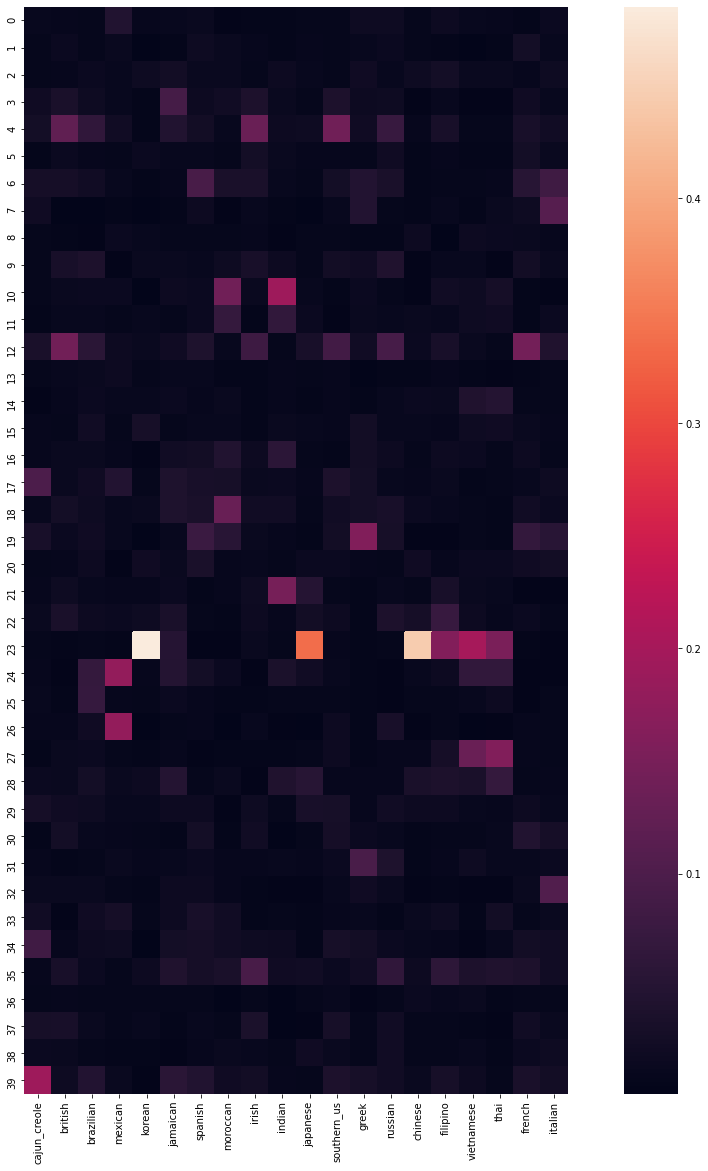

In [ ]:
plot_matrix(compute_topic_cuisine_matrix(lda2, corpus2, recipes))


Чем темнее квадрат в матрице, тем больше связь этой темы с данной кухней. Мы видим, что у нас есть темы, которые связаны с несколькими кухнями. Такие темы показывают набор ингредиентов, которые популярны в кухнях нескольких народов, то есть указывают на схожесть кухонь этих народов. Некоторые темы распределены по всем кухням равномерно, они показывают наборы продуктов, которые часто используются в кулинарии всех стран. 